In [ ]:
import os
import pandas as pd
import numpy as np
from scipy import stats


bai_dir = r"../Rawdat/BAI"
output_dir = os.path.join(bai_dir, "summary_figures_zscore")
os.makedirs(output_dir, exist_ok=True)


mean_files = [f for f in os.listdir(bai_dir) if f.endswith("_mean.csv")]
if not mean_files:
    raise FileNotFoundError("❌ ")

trend_records = []


for fname in mean_files:
    site = fname.replace("BAI_", "").replace("_mean.csv", "")
    fpath = os.path.join(bai_dir, fname)
    df = pd.read_csv(fpath)

    if not {"Year", "Mean_BAI"}.issubset(df.columns):
        print(f"⚠️ ")
        continue

    # 筛选年份区间：1901–2015
    df = df.dropna(subset=["Mean_BAI"])
    df = df[(df["Year"] >= 1901) & (df["Year"] <= 2000)]
    if len(df) < 10:
        print(f"⚠️ {site} ")
        continue

 
    mean_bai = df["Mean_BAI"].mean()


    mean_val = df["Mean_BAI"].mean()
    std_val = df["Mean_BAI"].std(ddof=1)
    if std_val == 0 or np.isnan(std_val):
        continue
    df["Z_BAI"] = (df["Mean_BAI"] - mean_val) / std_val


    slope, intercept, r_value, p_value, _ = stats.linregress(df["Year"], df["Z_BAI"])
    r2 = r_value ** 2
    trend_type = (
        "Increasing" if p_value < 0.05 and slope > 0 else
        "Decreasing" if p_value < 0.05 and slope < 0 else
        "No trend"
    )

    trend_records.append({
        "Site": site,
        "StartYear": int(df["Year"].min()),
        "EndYear": int(df["Year"].max()),
        "nYears": len(df),
        "Mean_BAI": mean_bai,
        "Slope": slope,
        "p_value": p_value,
        "R2": r2,
        "TrendType": trend_type
    })

trend_df = pd.DataFrame(trend_records)


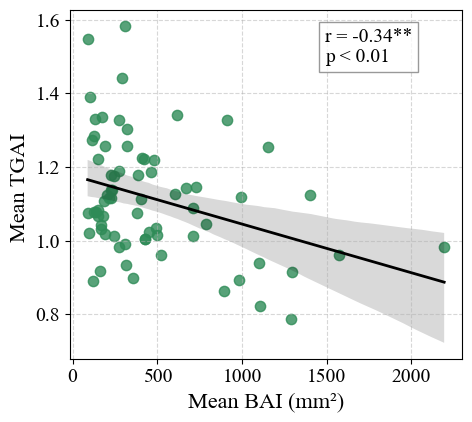

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
df_TGAI = pd.read_csv(r"../Rawdat/site4-71.csv")
trend_df['Site'] = trend_df['Site'].str.strip().str.lower()
df_TGAI['site'] = df_TGAI['site'].str.strip().str.lower()
df_merge = pd.merge(trend_df, df_TGAI, left_on='Site', right_on='site', how='inner')
dfCS = df_merge.dropna(subset=['Mean', 'Mean_BAI'])
r, p = stats.pearsonr(dfCS['Mean'], dfCS['Mean_BAI'])

if p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = 'ns'

plt.figure(figsize=(5,4.5))


sns.regplot(
    data=dfCS,
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 55, 'color': 'seagreen', 'alpha': 0.8},
    line_kws={'color': 'black', 'lw': 2},
    ci=95
)

text = f"r = {r:.2f}{sig}\n" + (f"p < 0.01" if p < 0.01 else f"p = {p:.3f}")
plt.text(
    0.65, 0.85, text,
    transform=plt.gca().transAxes,
    fontsize=14,
    fontfamily="Times New Roman",
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
)


plt.ylabel("Mean TGAI ")
plt.xlabel("Mean BAI (mm²)")
plt.grid(True, linestyle='--', alpha=0.5)
# plt.savefig(r'../Rawdat/Fig/Fig3-C.jpg', dpi=600, bbox_inches='tight')
plt.show()


📈 Pearson r = -0.295, p = 1.259e-02 (*)


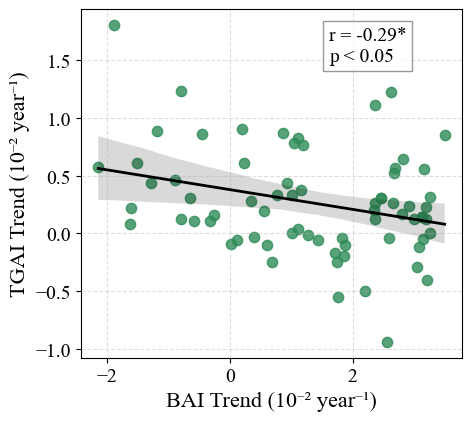

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
dfcsm=df_merge
r, p = stats.pearsonr(dfcsm['Slope_Mean']*100, dfcsm['Slope']*100)
sig = "**" if p < 0.01 else "*" if p < 0.05 else "ns"
print(f"📈 Pearson r = {r:.3f}, p = {p:.3e} ({sig})")
dfcsm['Slope_Mean100'] = dfcsm['Slope_Mean']*100
dfcsm['Slope100'] = dfcsm['Slope']*100
plt.figure(figsize=(5, 4.5))
sns.regplot(
    x='Slope100', y='Slope_Mean100', data=dfcsm,
    scatter_kws={'s': 55, 'color': 'seagreen', 'alpha': 0.8},
    line_kws={'color': 'black', 'lw': 2},
    ci=95
)
text = f"r = {r:.2f}{sig}\n" + (f"p < 0.05" if p < 0.05 else f"p = {p:.3f}")
plt.text(
    0.65, 0.85, text,
    transform=plt.gca().transAxes,
    fontsize=14,
    fontfamily="Times New Roman",
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
)
# 美化
plt.ylabel("TGAI Trend (10⁻² year⁻¹)")
plt.xlabel("BAI Trend (10⁻² year⁻¹)")
# plt.title("Relationship between TGAI and BAI Trends")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
# plt.savefig(r'../Rawdat/Fig/FigS7.jpg', dpi=600, bbox_inches='tight')
plt.show()



===  Pearson  ===
    Zone         r         p
0   Arid -0.453264  0.029846
1  Humid -0.377250  0.008212

=== ANCOVA===
                    sum_sq    df          F    PR(>F)
C(Zone)           0.150390   1.0   6.969730  0.010304
Mean_BAI          0.252319   1.0  11.693585  0.001072
Mean_BAI:C(Zone)  0.003989   1.0   0.184881  0.668592
Residual          1.445695  67.0        NaN       NaN


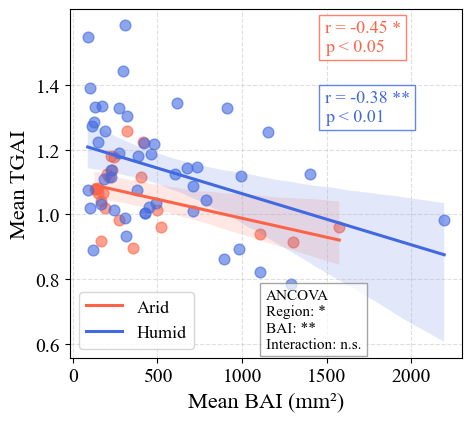

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
df = df_merge.dropna(subset=['Mean', 'Mean_BAI', 'ai_v3']).copy()
df['Zone'] = np.where(df['ai_v3'] <= 0.65, 'Arid', 'Humid')
stats_list = []
for zone, sub in df.groupby('Zone'):
    r, p = stats.pearsonr(sub['Mean'], sub['Mean_BAI'])
    stats_list.append({'Zone': zone, 'r': r, 'p': p})
stats_df = pd.DataFrame(stats_list)
print("\n===  Pearson  ===")
print(stats_df)
model = smf.ols("Mean ~ Mean_BAI * C(Zone)", data=df).fit()
ancova_res = anova_lm(model, typ=2)
print("\n=== ANCOVA===")
print(ancova_res)
p_zone = ancova_res.loc['C(Zone)', 'PR(>F)']
p_bai  = ancova_res.loc['Mean_BAI', 'PR(>F)']
p_inter = ancova_res.loc['Mean_BAI:C(Zone)', 'PR(>F)']

def signif(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'n.s.'
def p_to_label(p):
    if p < 0.001:
        return "***", "p < 0.001"
    elif p < 0.01:
        return "**", "p < 0.01"
    elif p < 0.05:
        return "*", "p < 0.05"
    else:
        return "n.s.", "n.s."
ancova_text = (
    "ANCOVA\n"
    f"Region: {signif(p_zone)}\n"
    f"BAI: {signif(p_bai)}\n"
    f"Interaction: {signif(p_inter)}"
)
plt.figure(figsize=(5, 4.5))
palette = {'Arid': 'tomato', 'Humid': 'royalblue'}
sns.regplot(
    data=df[df['Zone'] == 'Arid'],
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 60, 'color': 'tomato', 'alpha': 0.6},
    line_kws={'color': 'tomato', 'lw': 2.2},
    ci=95
)
sns.regplot(
    data=df[df['Zone'] == 'Humid'],
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 60, 'color': 'royalblue', 'alpha': 0.6},
    line_kws={'color': 'royalblue', 'lw': 2.2},
    ci=95
)
for i, row in stats_df.iterrows():
    zone, r37, p37 = row['Zone'], row['r'], row['p']

    sig, p_label = p_to_label(p37)
    text = f"r = {r37:.2f} {sig}\n{p_label}"

    if zone == "Arid":
        plt.text(
            0.65, 0.88, text,
            transform=plt.gca().transAxes,
            fontsize=13, color='tomato',
            bbox=dict(facecolor='white', edgecolor='tomato', alpha=0.8)
        )
    else:
        plt.text(
            0.65, 0.68, text,
            transform=plt.gca().transAxes,
            fontsize=13, color='royalblue',
            bbox=dict(facecolor='white', edgecolor='royalblue', alpha=0.8)
        )
plt.text(
    0.5, 0.02, ancova_text,
    transform=plt.gca().transAxes,
    fontsize=11,
    va='bottom', ha='left',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
)

plt.ylabel("Mean TGAI")
plt.xlabel("Mean BAI (mm²)")
plt.yticks([0.6, 0.8, 1.0, 1.2, 1.4])
plt.xticks([0, 500, 1000, 1500, 2000])
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend(labels=['Arid', 'Humid'], loc=3, fontsize=13)
# plt.savefig(r'../Rawdat/Fig/Fig3-D.jpg', dpi=600, bbox_inches='tight')
plt.show()


-0.30777157439291614 0.02102546345170449


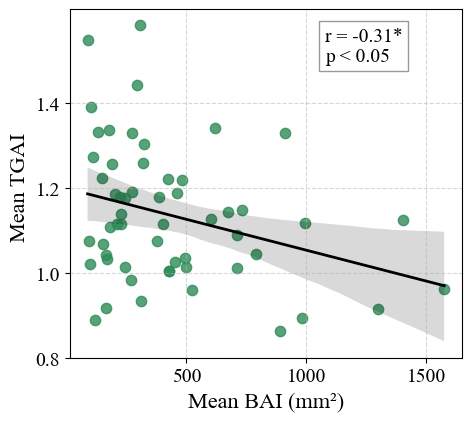

In [ ]:
df_TGAI5 = pd.read_csv(r"../Rawdat/site5-56.csv")
trend_df['Site'] = trend_df['Site'].str.strip().str.lower()
df_TGAI5['site'] = df_TGAI5['site'].str.strip().str.lower()

df_merge37 = pd.merge(trend_df, df_TGAI5, left_on='Site', right_on='site', how='inner')


dfCS = df_merge37.dropna(subset=['Mean', 'Mean_BAI'])
r, p = stats.pearsonr(dfCS['Mean'], dfCS['Mean_BAI'])

if p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = 'ns'

plt.figure(figsize=(5,4.5))


sns.regplot(
    data=dfCS,
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 55, 'color': 'seagreen', 'alpha': 0.8},
    line_kws={'color': 'black', 'lw': 2},
    ci=95
)
print(r, p)
text = f"r = {r:.2f}{sig}\n" + (f"p < 0.01" if p < 0.01 else f"p < 0.05")
plt.text(
    0.65, 0.85, text,
    transform=plt.gca().transAxes,
    fontsize=14,
    fontfamily="Times New Roman",
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
)
plt.ylabel("Mean TGAI ")
plt.yticks([0.8,1.0,1.2,1.4])
# plt.xticks([0,500,1000,1500,2000])
plt.xlabel("Mean BAI (mm²)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig(r'../Rawdat/Fig/FigS9-C.jpg', dpi=600, bbox_inches='tight')
plt.show()

📈 Pearson r = -0.216, p = 1.092e-01 (ns)


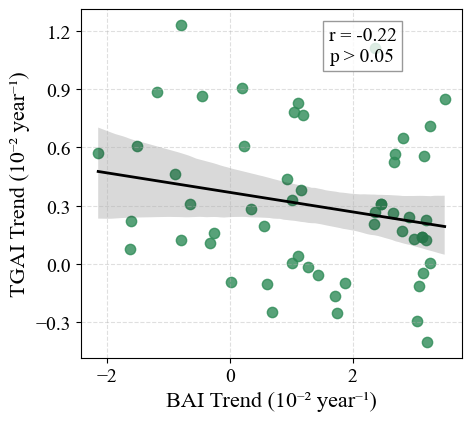

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
df_merge37CS= df_merge37
r, p = stats.pearsonr(df_merge37CS['Slope_Mean']*100, df_merge37CS['Slope']*100)
sig = "**" if p < 0.01 else "*" if p < 0.05 else "ns"
print(f"📈 Pearson r = {r:.3f}, p = {p:.3e} ({sig})")
df_merge37CS['Slope_Mean100'] = df_merge37CS['Slope_Mean']*100
df_merge37CS['Slope100'] = df_merge37CS['Slope']*100
plt.figure(figsize=(5, 4.5))
sns.regplot(
    x='Slope100', y='Slope_Mean100', data=df_merge37CS,
    scatter_kws={'s': 55, 'color': 'seagreen', 'alpha': 0.8},
    line_kws={'color': 'black', 'lw': 2},
    ci=95
)
text = f"r = {r:.2f}\n" + (f"p < 0.05" if p < 0.05 else f"p > 0.05")
plt.text(
    0.65, 0.85, text,
    transform=plt.gca().transAxes,
    fontsize=14,
    fontfamily="Times New Roman",
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
)
# 美化
plt.ylabel("TGAI Trend (10⁻² year⁻¹)")
plt.yticks([-0.3,0.0,0.3,0.6,0.9,1.2])
plt.xlabel("BAI Trend (10⁻² year⁻¹)")
# plt.title("Relationship between TGAI and BAI Trends")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
# plt.savefig(r'../Rawdat/Fig/FigS9-D.jpg', dpi=600, bbox_inches='tight')
plt.show()